In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

C:\ProgramData\Anaconda3\envs\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\envs\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
df = pd.read_pickle('../../../mlcourse_data/mobile_app_launches_sessions_payments.pkl')

In [7]:
df.keys()

dict_keys(['X_train', 'y_train', 'X_valid', 'y_valid'])

In [17]:
df['X_train'].head()

,sessions1,sessions2,sessions3,sessions4,sessions5,sessions6,sessions7,sessions8,launches1,launches2,...,num_payments7,num_payments8,sum_payments1,sum_payments2,sum_payments3,sum_payments4,sum_payments5,sum_payments6,sum_payments7,sum_payments8
941782,1,1,19,31,61,109,136,147,1,1,...,0,0,0,0,0,0,0,0,0,0
466960,1,5,5,5,5,5,5,5,1,6,...,0,0,0,0,0,0,0,0,0,0
704609,6,24,39,46,61,66,68,68,6,24,...,0,0,0,0,0,0,0,0,0,0
973929,8,18,33,45,52,62,69,71,8,18,...,0,0,0,0,0,0,0,0,0,0
973936,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df['X_train'].columns

Index(['sessions1', 'sessions2', 'sessions3', 'sessions4', 'sessions5',
       'sessions6', 'sessions7', 'sessions8', 'launches1', 'launches2',
       'launches3', 'launches4', 'launches5', 'launches6', 'launches7',
       'launches8', 'num_payments1', 'num_payments2', 'num_payments3',
       'num_payments4', 'num_payments5', 'num_payments6', 'num_payments7',
       'num_payments8', 'sum_payments1', 'sum_payments2', 'sum_payments3',
       'sum_payments4', 'sum_payments5', 'sum_payments6', 'sum_payments7',
       'sum_payments8'],
      dtype='object')

In [19]:
(df['X_train']['sum_payments8']>0).value_counts()

False    775124
True      49356
Name: sum_payments8, dtype: int64

In [23]:
X_train, X_valid, y_train, y_valid = df['X_train'], df['X_valid'], df['y_train'], df['y_valid']

In [24]:
y_train.mean(), y_valid.mean()

(0.0763147680962546, 0.06944409068654503)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
forest = RandomForestClassifier(n_estimators=300, class_weight='balanced', n_jobs=-1, random_state=17)

In [27]:
%%time
forest.fit(X_train, y_train)

Wall time: 6min 19s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=17, verbose=0, warm_start=False)

In [28]:
forest_pred_probs = forest.predict_proba(X_valid)[:, 1]

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

**Is that good?**

In [33]:
roc_auc_score(y_valid, forest_pred_probs)

0.9647325914788966

Baseline, accuracy can be misleading

In [42]:
accuracy_score(y_valid, X_valid['sum_payments8']>0)

0.9879156301560214

In [61]:
accuracy_score(y_valid, forest_pred_probs>0.5)

0.9857364814956318

In [62]:
pred_df = pd.DataFrame({'true': y_valid, 'pred_forest': forest_pred_probs, 'pred_baseline':(X_valid['sum_payments8']>0).astype('int')})

In [63]:
pred_df.sort_values(by='pred_forest', inplace=True, ascending=False)
pred_df.head()

,true,pred_forest,pred_baseline
12595,1,1.0,1
76749,1,1.0,1
18479,1,1.0,1
45273,1,1.0,1
43080,1,1.0,1


In [64]:
pred_df.iloc[:50000]['true'].mean()

0.43704

In [65]:
y_valid.mean()

0.06944409068654503

In [66]:
lift_forest = pred_df.iloc[:50000]['true'].mean()/y_valid.mean()
lift_forest

6.29340805933654

In [67]:
lift_baseline = pred_df.sort_values(by='pred_baseline', ascending=False).iloc[:50000]['true'].mean()/y_valid.mean()
lift_baseline

5.8703339041486675

**Precision/recall**

In [68]:
precision_score(y_valid, forest_pred_probs>0.5), \
    precision_score(y_valid, X_valid['sum_payments8']>0)

(0.9615129710282143, 1.0)

In [69]:
recall_score(y_valid, forest_pred_probs>0.5), \
    recall_score(y_valid, X_valid['sum_payments8']>0)

(0.8277365718477464, 0.825984187790366)

In [70]:
from sklearn.metrics import f1_score

In [71]:
f1_score(y_valid, forest_pred_probs>0.5), \
    f1_score(y_valid, X_valid['sum_payments8']>0)

(0.8896237571722657, 0.904700263357586)

Text(0.5, 1.0, '2-class Precision-Recall curve: Random Forest')

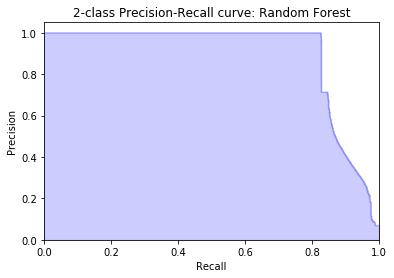

In [79]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, thres = precision_recall_curve(y_valid, forest_pred_probs)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Random Forest')

In [110]:
for i in range(len(thres)):
    if precision[i]>0.5:
        index=i
        print('Threshold is: ', thres[index])
        break

Threshold is:  0.19348932084960516


Text(0, 0.5, 'metric')

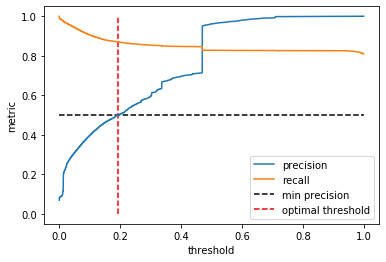

In [111]:
plt.plot(thres, precision[:-1], label='precision')
plt.plot(thres, recall[:-1], label='recall')
plt.hlines(y=0.5, xmin=0, xmax=1, label='min precision',linestyles='dashed')
plt.vlines(x=thres[index], ymin=0, ymax=1, color='red', label='optimal threshold', linestyles='dashed')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('metric')

In [113]:
precision_score(y_valid, forest_pred_probs>thres[index]), \
    recall_score(y_valid, forest_pred_probs>thres[index])

(0.5017758438198283, 0.8693862580487407)

In [115]:
precision_score(y_valid, X_valid['sum_payments8']>0), \
    recall_score(y_valid, X_valid['sum_payments8']>0)

(1.0, 0.825984187790366)

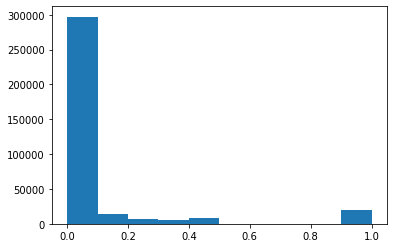

In [118]:
plt.hist(forest_pred_probs);

**Feature Importance**

In [122]:
pd.DataFrame(forest.feature_importances_, index=X_train.columns, 
             columns=['importance']).sort_values(by='importance', ascending=False)

,importance
num_payments8,0.120221
sum_payments8,0.117659
sum_payments7,0.074976
num_payments7,0.072070
num_payments6,0.063004
sum_payments6,0.042955
sessions8,0.040348
launches8,0.039541
sum_payments5,0.036355
num_payments5,0.033727


In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [131]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[328811      0]
 [  4270  20268]]


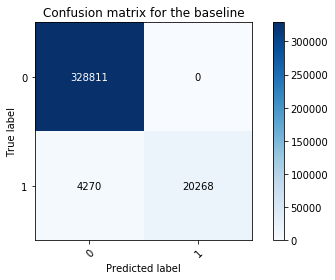

In [133]:
plot_confusion_matrix(y_true=y_valid, y_pred=(X_valid['sum_payments8']>0), 
                      classes=forest.classes_, title='Confusion matrix for the baseline');

Confusion matrix, without normalization
[[307629  21182]
 [  3205  21333]]


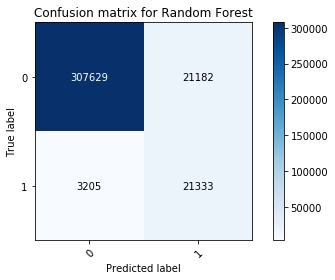

In [135]:
plot_confusion_matrix(y_true=y_valid, y_pred=forest_pred_probs>thres[index], 
                      classes=forest.classes_, title='Confusion matrix for Random Forest');

### Logistic Regression

In [137]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [138]:
scaler = StandardScaler()

In [139]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [140]:
logit = LogisticRegression(n_jobs=-1, random_state=17, class_weight='balanced', solver='sag')

In [141]:
%%time
logit.fit(X_train_scaled, y_train)

Wall time: 1min 11s


C:\ProgramData\Anaconda3\envs\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=17, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [143]:
logit_pred_probs = logit.predict_proba(X_valid_scaled)[:,1]

In [144]:
roc_auc_score(y_valid, logit_pred_probs)

0.9764940094392004

Baseline, accuracy can be misleading

In [42]:
accuracy_score(y_valid, X_valid['sum_payments8']>0)

0.9879156301560214

In [145]:
accuracy_score(y_valid, logit_pred_probs>0.5)

0.9642449815904389

In [146]:
pred_df2 = pd.DataFrame({'true': y_valid, 'pred_logit': logit_pred_probs, 'pred_baseline':(X_valid['sum_payments8']>0).astype('int')})

In [147]:
pred_df2.sort_values(by='pred_logit', inplace=True, ascending=False)
pred_df2.head()

,true,pred_logit,pred_baseline
62466,1,1.0,1
10587,1,1.0,1
32466,1,1.0,1
52663,1,1.0,1
52996,1,1.0,1


In [148]:
pred_df2.iloc[:50000]['true'].mean()

0.44864

In [149]:
y_valid.mean()

0.06944409068654503

In [150]:
lift_logit = pred_df2.iloc[:50000]['true'].mean()/y_valid.mean()
lift_logit

6.4604489102616345

In [151]:
lift_baseline = pred_df.sort_values(by='pred_baseline', ascending=False).iloc[:50000]['true'].mean()/y_valid.mean()
lift_baseline

5.8703339041486675

**Precision/recall**

In [152]:
precision_score(y_valid, logit_pred_probs>0.5), \
    precision_score(y_valid, X_valid['sum_payments8']>0)

(0.6931965723188782, 1.0)

In [153]:
recall_score(y_valid, logit_pred_probs>0.5), \
    recall_score(y_valid, X_valid['sum_payments8']>0)

(0.8703235797538512, 0.825984187790366)

In [70]:
from sklearn.metrics import f1_score

In [154]:
f1_score(y_valid, logit_pred_probs>0.5), \
    f1_score(y_valid, X_valid['sum_payments8']>0)

(0.7717269540707549, 0.904700263357586)

Text(0.5, 1.0, '2-class Precision-Recall curve: Logistic Regression')

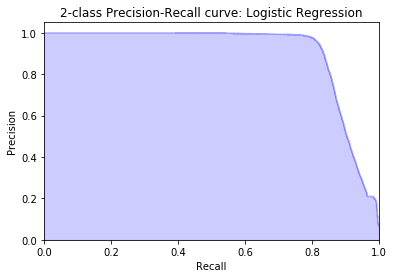

In [155]:
precision, recall, thres = precision_recall_curve(y_valid, logit_pred_probs)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Logistic Regression')

In [156]:
for i in range(len(thres)):
    if precision[i]>0.5:
        index=i
        print('Threshold is: ', thres[index])
        break

Threshold is:  0.28903163252611486


Text(0, 0.5, 'metric')

C:\ProgramData\Anaconda3\envs\python37\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


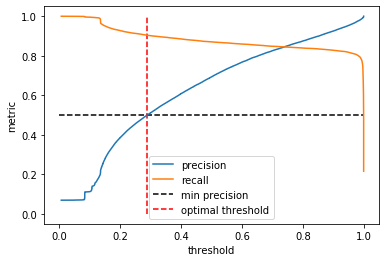

In [157]:
plt.plot(thres, precision[:-1], label='precision')
plt.plot(thres, recall[:-1], label='recall')
plt.hlines(y=0.5, xmin=0, xmax=1, label='min precision',linestyles='dashed')
plt.vlines(x=thres[index], ymin=0, ymax=1, color='red', label='optimal threshold', linestyles='dashed')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('metric')

In [158]:
precision_score(y_valid, logit_pred_probs>thres[index]), \
    recall_score(y_valid, logit_pred_probs>thres[index])

(0.5000225438477839, 0.903904148667373)

In [159]:
precision_score(y_valid, X_valid['sum_payments8']>0), \
    recall_score(y_valid, X_valid['sum_payments8']>0)

(1.0, 0.825984187790366)

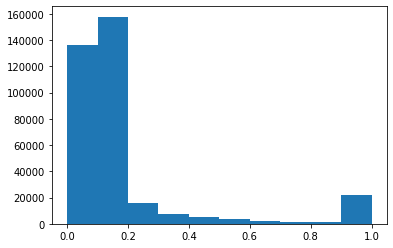

In [160]:
plt.hist(logit_pred_probs);

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Confusion matrix, without normalization
[[328811      0]
 [  4270  20268]]


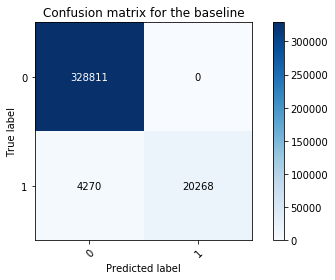

In [162]:
plot_confusion_matrix(y_true=y_valid, y_pred=(X_valid['sum_payments8']>0), 
                      classes=forest.classes_, title='Confusion matrix for the baseline');

Confusion matrix, without normalization
[[306633  22178]
 [  2358  22180]]


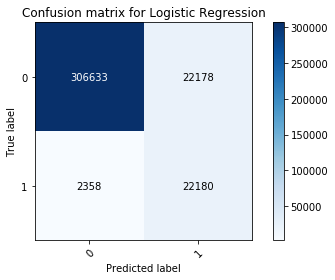

In [161]:
plot_confusion_matrix(y_true=y_valid, y_pred=logit_pred_probs>thres[index], 
                      classes=forest.classes_, title='Confusion matrix for Logistic Regression');